<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
import os

# Specify the directory path
directory_path = '//Users/mirthedankloff/Documents/XAI_Bias_Error/COMPAS'

# Traverse the directory and print the names of all files
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Load cleaned Compas data

In [173]:
#compas_s = pd.read_csv("/content/final_preprocessed_compas(2).csv")
#ofercompas = pd.read_csv("/content/propublica_data_for_fairml.csv")
#originalcompas = pd.read_csv("/content/compas-scores-two-years-violent.csv")
#cox_violent_filt = pd.read_csv('/content/cox-violent-parsed_filt.csv')
compas_2 = pd.read_csv('/content/cleaned_compas_data.csv')

In [174]:
compas_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       7214 non-null   int64 
 1   sex                      7214 non-null   object
 2   age                      7214 non-null   int64 
 3   age_cat                  7214 non-null   object
 4   race                     7214 non-null   object
 5   decile_score             7214 non-null   int64 
 6   priors_count             7214 non-null   int64 
 7   is_recid                 7214 non-null   int64 
 8   is_violent_recid         7214 non-null   int64 
 9   score_text               7214 non-null   object
 10  v_decile_score           7214 non-null   int64 
 11  priors_count.1           7214 non-null   int64 
 12  event                    7214 non-null   int64 
 13  two_year_recid           7214 non-null   int64 
 14  sex_Female               7214 non-null  

In [175]:
#Check if is_recid and two year recid are the same
if (compas_2['is_recid'] == compas_2['two_year_recid']).any():
    print("same")
else:
    print("not same")

same


In [176]:
#Select Features
X = compas_2.drop(['two_year_recid', 'id', 'score_text', 'v_decile_score', 'priors_count.1', 'is_recid', 'is_violent_recid', 'sex', 'age_cat', 'race', 'event', 'age_cat_Greater than 45', 'age_cat_25 - 45', 'age_cat_Less than 25'],axis=1)
Y = compas_2['two_year_recid']

Y.shape[0]
X.shape[0]


7214

# Train Random Forest Classifier

In [177]:
#Train model

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True, stratify = Y)

model = RandomForestClassifier()
model.fit(X_train, Y_train)

#predictions
Yhat = model.predict(X_test)
len(Yhat)


2165

# Collect the errors

In [178]:
#Create data frame to contain the predicted and true classes - converting y_hat np to df
predictions = pd.DataFrame()
predictions['predicted_class'] = Yhat.tolist()
predictions = predictions.set_index(X_test.index)
predictions['true_class'] = Y_test

#calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to the test data
entire_dataset = X_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = entire_dataset['errors']
df_out = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
entire_dataset[entire_dataset['errors']==1]

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)


Accuracy: 0.6171
[[789 400]
 [429 547]]


# Selecting 4 labels (FP, FN, TP, TN)

In [179]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
entire_dataset = entire_dataset.apply(get_error_type, axis=1)

#print(data_pred.columns)
print(entire_dataset)

      age  decile_score  priors_count  sex_Female  sex_Male  \
5654   28             3             0           0         1   
5945   35             2             0           1         0   
3529   27             7             2           0         1   
1107   35             8            10           1         0   
222    48             1             0           0         1   
...   ...           ...           ...         ...       ...   
1459   30             7             6           0         1   
2506   23            10             5           0         1   
2044   28             4             2           0         1   
1077   32             5             6           0         1   
2175   46             1             0           0         1   

      race_African-American  race_Asian  race_Caucasian  race_Hispanic  \
5654                      0           0               1              0   
5945                      0           0               0              1   
3529                 

In [180]:
#Check if there are any FP/FN
if (entire_dataset['FP'] == 1).any():
    print("There's at least one occurrence of 1 in the column.")
else:
    print("There's no occurrence of 1 in the column.")

There's at least one occurrence of 1 in the column.


# add categorical for error type to make visualizations

In [181]:
# Extract dummy variables for error labels
error_type = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
entire_dataset['Error_Type'] = error_type.idxmax(axis=1).astype('category')

entire_dataset = pd.merge(entire_dataset, compas_2[['sex', 'race']], left_index=True, right_index=True)


In [182]:
#change objects to categories
for col in ['sex', 'race']:
    entire_dataset[col] = entire_dataset[col].astype('category')

entire_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 5654 to 2175
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    2165 non-null   int64   
 1   decile_score           2165 non-null   int64   
 2   priors_count           2165 non-null   int64   
 3   sex_Female             2165 non-null   int64   
 4   sex_Male               2165 non-null   int64   
 5   race_African-American  2165 non-null   int64   
 6   race_Asian             2165 non-null   int64   
 7   race_Caucasian         2165 non-null   int64   
 8   race_Hispanic          2165 non-null   int64   
 9   race_Native American   2165 non-null   int64   
 10  race_Other             2165 non-null   int64   
 11  predicted_class        2165 non-null   int64   
 12  true_class             2165 non-null   int64   
 13  errors                 2165 non-null   int64   
 14  TP                     2165 non-null 


# Barchart 4 labels (FP, FN, TP, TN)

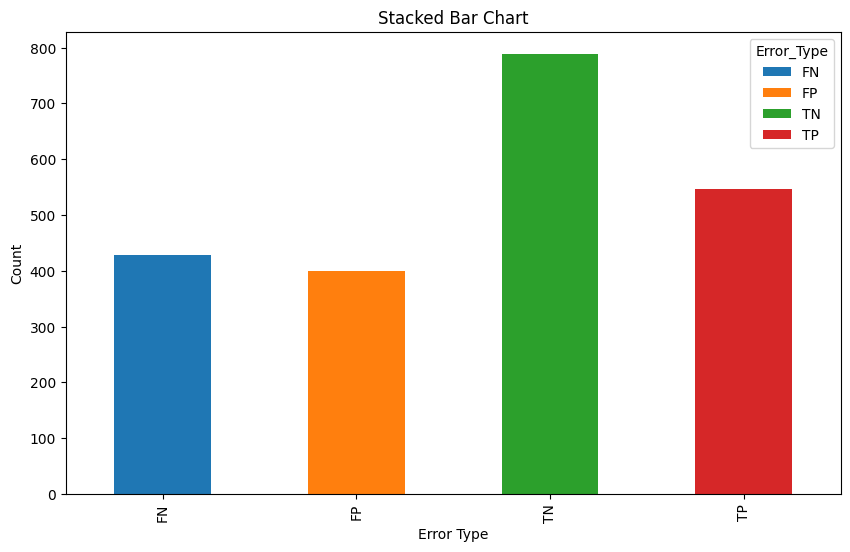

In [183]:
errors_df = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Melt the DataFrame for easy plotting
melted_df = pd.melt(errors_df, var_name='Error_Type', value_name='Count')

# Pivot the DataFrame for stacked bar chart
pivot_df = melted_df.pivot_table(index='Error_Type', columns='Error_Type', values='Count', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Stacked Bar Chart')

# Show the plot
plt.show()


# Barchart error labels per demographic group

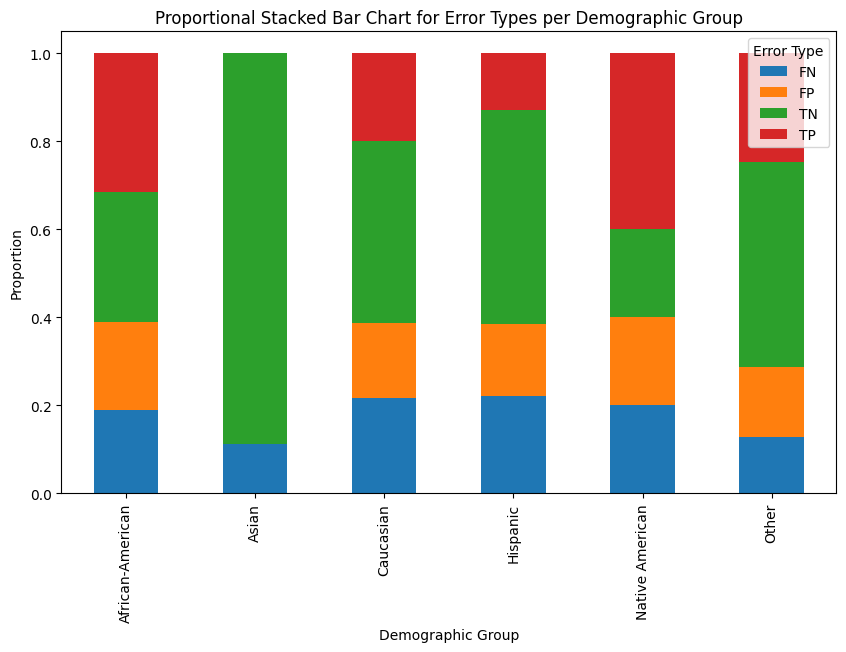

In [184]:
#Group data by 'race' and 'Error_Type' and count occurrences
race_error_counts = entire_dataset.groupby(['race', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
race_error_proportions = race_error_counts.div(race_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
race_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()

# Barchart error labels per gender

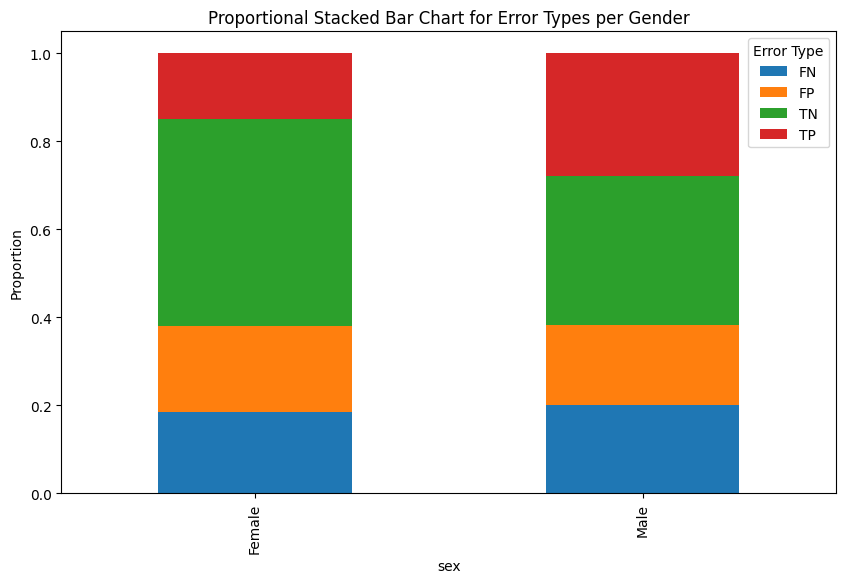

In [185]:
#Group data by 'race' and 'Error_Type' and count occurrences
sex_error_counts = entire_dataset.groupby(['sex', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
sex_error_proportions = sex_error_counts.div(sex_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
sex_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Gender')
plt.xlabel('sex')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()

# Bar Chart Error labels per Age

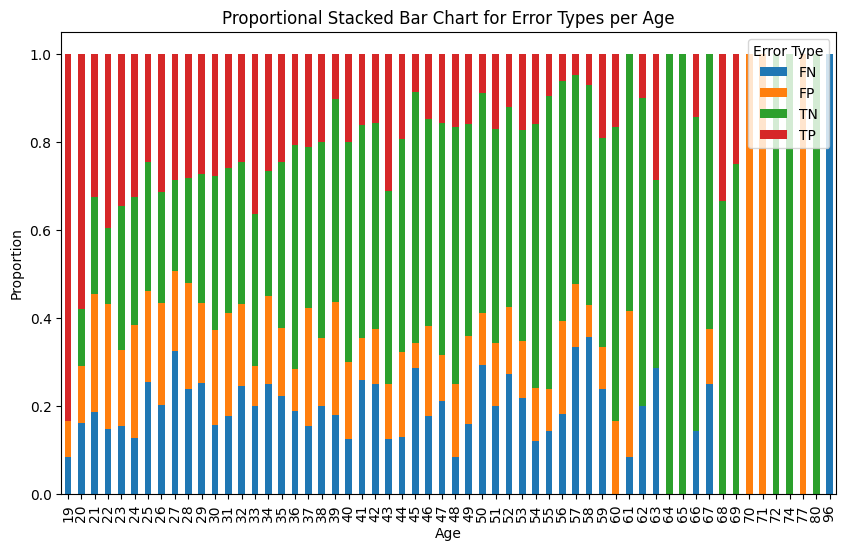

In [186]:
# Group data by 'age' and 'Error_Type' and count occurrences
age_error_counts = entire_dataset.groupby(['age', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
age_error_proportions = age_error_counts.div(age_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
age_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Age')
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()


# Boxplot error label per age with jitter

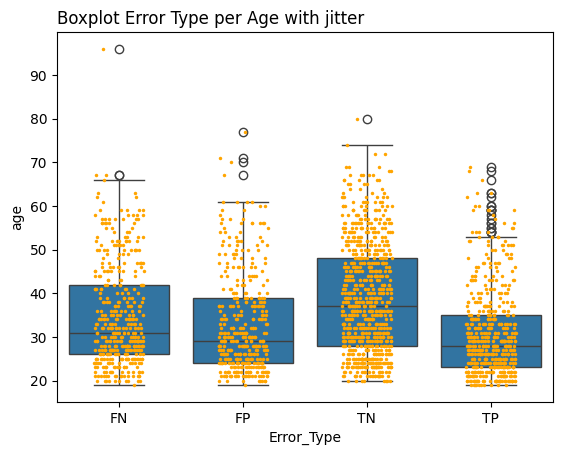

In [187]:
# boxplot
ax = sns.boxplot(x='Error_Type', y='age', data=entire_dataset)
# add stripplot
ax = sns.stripplot(x='Error_Type', y='age', data=entire_dataset, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot Error Type per Age with jitter", loc="left")

# show the graph
plt.show()

# Violinplot

In [188]:
entire_dataset.head()

,age,decile_score,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,...,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type,sex,race
5654,28,3,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,TN,Male,Caucasian
5945,35,2,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,TN,Female,Hispanic
3529,27,7,2,0,1,1,0,0,0,0,...,1,1,0,1,0,0,0,TP,Male,African-American
1107,35,8,10,1,0,0,0,0,1,0,...,1,0,1,0,0,0,1,FP,Female,Hispanic
222,48,1,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,TN,Male,African-American


Violin plot as combination of boxplot and kernel density plot.

The width represents the densitiy of datapoints at a certian value. Middle bar inside violin represents the interquartile range.


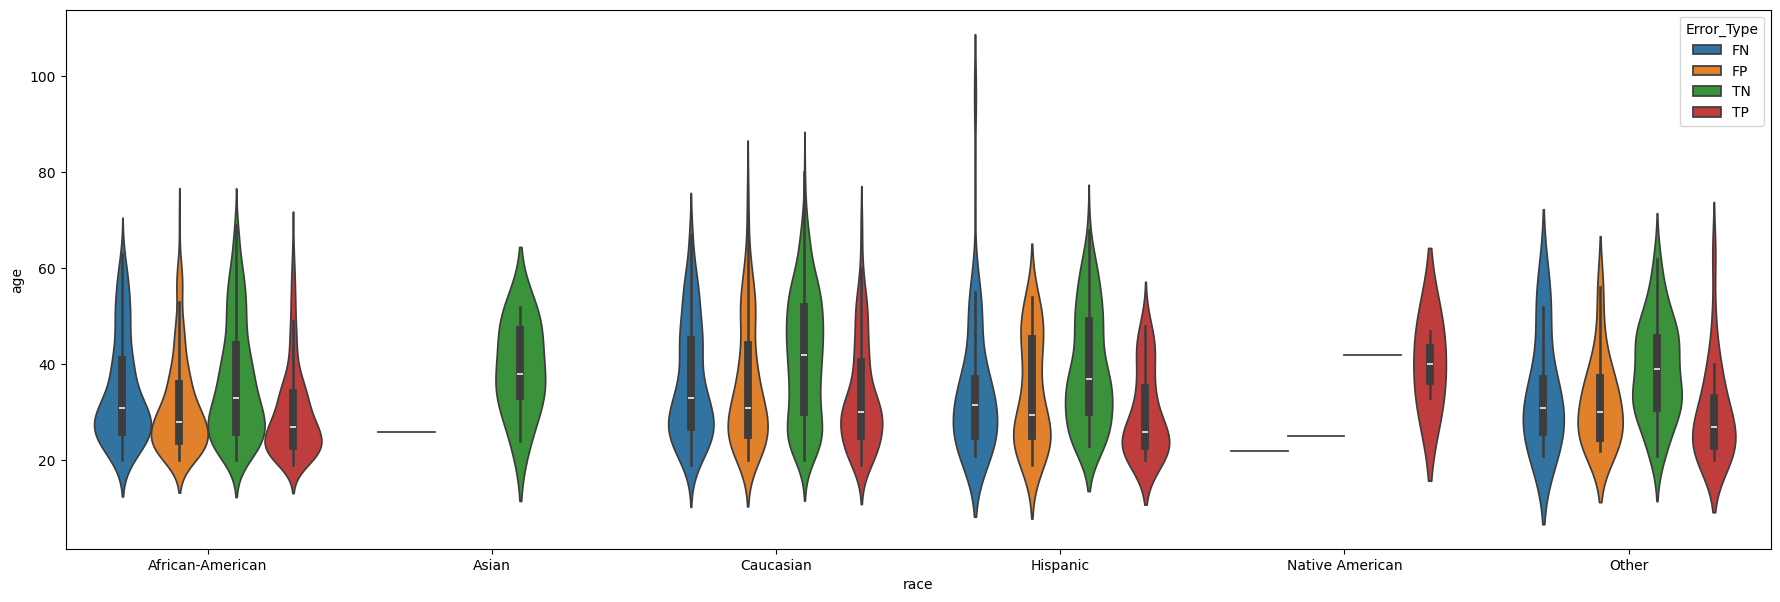

In [189]:
#sns.violinplot(x="Error_Type", y="age", data=entire_dataset)
#plt.show()

#sns.violinplot(x="Error_Type", y="age_cat", data=entire_dataset)
#plt.show()

#plt.figure(figsize=(3, 15))

#sns.violinplot(x="age", y="race", hue = "Error_Type", data=entire_dataset)
#plt.show()

#sns.violinplot(x="Error_Type", y="sex", data=entire_dataset)
#plt.show()

plt.figure(figsize=(22, 7))

sns.violinplot(x="race", y="age", hue = "Error_Type", data=entire_dataset)
plt.show()


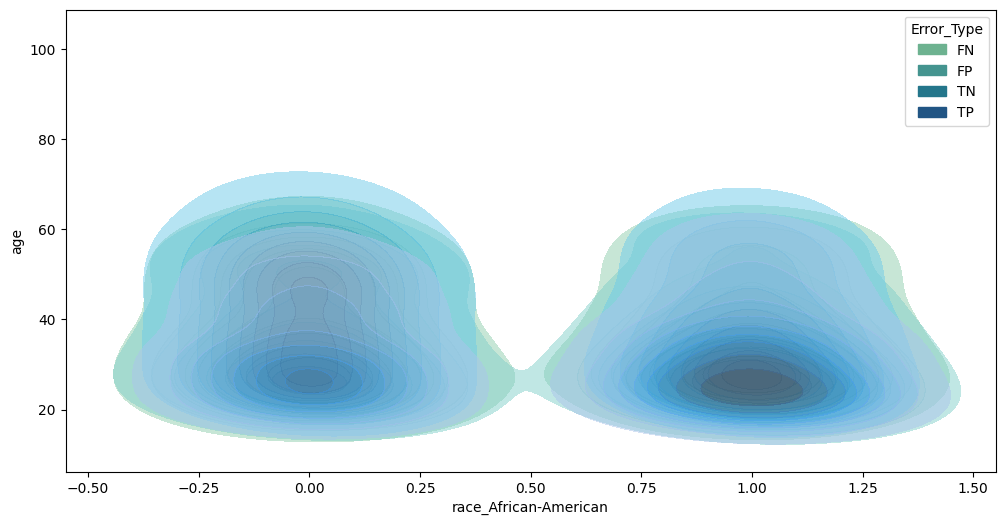

In [190]:
#race_categories = ['race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']
#entire_dataset['race_cat'] = pd.Categorical(entire_dataset['race'], categories=race_categories, ordered=True)

plt.figure(figsize=(12, 6))

sns.kdeplot(data=entire_dataset, x="race_African-American", y="age", hue="Error_Type", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)

plt.show()


# PCA

Each point represents an observation in entire_dataset. Points closer together have similar patterns across features. Culsters may indicate subgroups. Outliers deviate from the general pattern

# For all error labels

Explained Variance Ratio: PC1 = 0.21, PC2 = 0.17


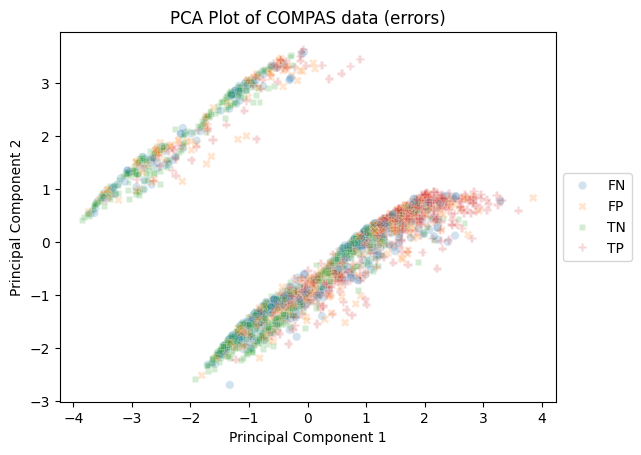

In [191]:
def pca_plot(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    scatterplot = sns.scatterplot(data=temp_dataset,x ='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="Error_Type", palette="tab10", style="Error_Type")

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

pca_plot(entire_dataset, 'PCA Plot of COMPAS data (errors)', 0.2)

# Scatterplot for TP/FN and TN/FP

Explained Variance Ratio: PC1 = 0.21, PC2 = 0.17


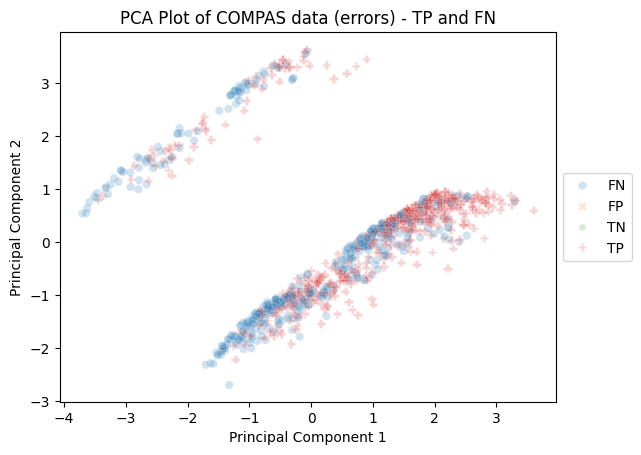

In [192]:
def pca_plot_TPFN(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TP' or 'FN'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TP', 'FN'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

# Example usage
pca_plot_TPFN(entire_dataset, 'PCA Plot of COMPAS data (errors) - TP and FN', 0.2)


Explained Variance Ratio: PC1 = 0.21, PC2 = 0.17


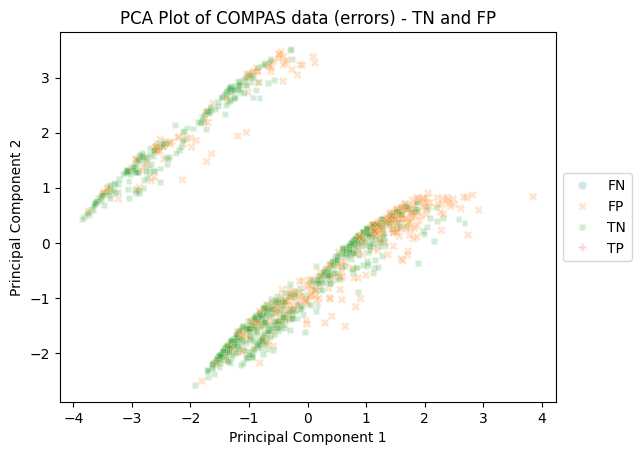

In [193]:
def pca_plot_TNFP(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TP' or 'FN'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TN', 'FP'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

# Example usage
pca_plot_TNFP(entire_dataset, 'PCA Plot of COMPAS data (errors) - TN and FP', 0.2)

# SHAP

In [194]:
!pip install shap
import shap

## SHAP

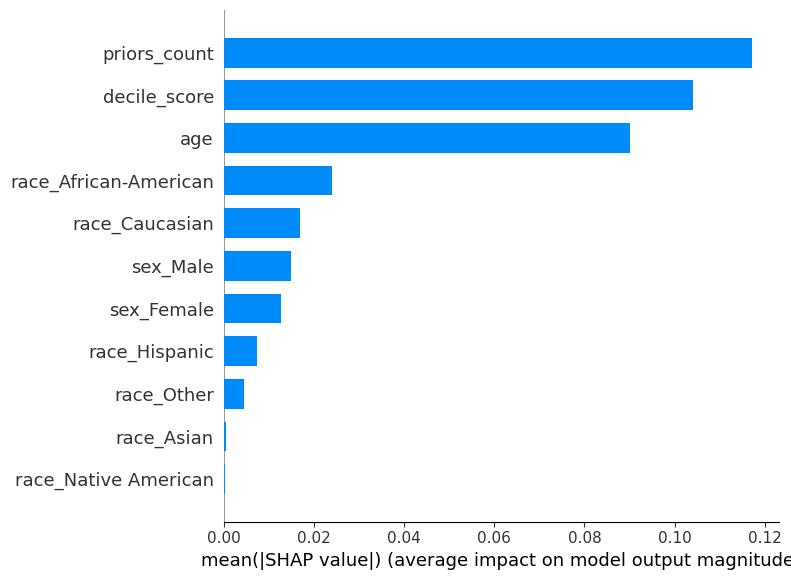

In [195]:
explainer = shap.TreeExplainer(model, approximate=True)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, plot_type = "bar")

In [196]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 5654 to 2175
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    2165 non-null   int64
 1   decile_score           2165 non-null   int64
 2   priors_count           2165 non-null   int64
 3   sex_Female             2165 non-null   int64
 4   sex_Male               2165 non-null   int64
 5   race_African-American  2165 non-null   int64
 6   race_Asian             2165 non-null   int64
 7   race_Caucasian         2165 non-null   int64
 8   race_Hispanic          2165 non-null   int64
 9   race_Native American   2165 non-null   int64
 10  race_Other             2165 non-null   int64
dtypes: int64(11)
memory usage: 267.5 KB


# Making the final dataset with feature values, error labels and Shap values

In [197]:
#Make a for loop where for every instance i in X_test (without the error labels) we calculate the SHAP values and add these to a new data_with_shap
#Later the removed error labels will be added to the dataset again

#Create copy for storing both original features and Shap values
data_with_shap = X_test.copy()

#loop through each instance i
for index, row in data_with_shap.iterrows():

  #Extract the feature values for current instance
  i_feature_values = row[['age', 'decile_score', 'priors_count', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']]

  #Calculate SHAP values for each instance
  shap_values = explainer.shap_values(i_feature_values)

  #Add new columns with SHAP values to data
  for i, feature in enumerate(['age', 'decile_score', 'priors_count', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']):
    data_with_shap.at[index, f'Shap_{feature}'] = shap_values[0][i]

print(data_with_shap)

      age  decile_score  priors_count  sex_Female  sex_Male  \
5654   28             3             0           0         1   
5945   35             2             0           1         0   
3529   27             7             2           0         1   
1107   35             8            10           1         0   
222    48             1             0           0         1   
...   ...           ...           ...         ...       ...   
1459   30             7             6           0         1   
2506   23            10             5           0         1   
2044   28             4             2           0         1   
1077   32             5             6           0         1   
2175   46             1             0           0         1   

      race_African-American  race_Asian  race_Caucasian  race_Hispanic  \
5654                      0           0               1              0   
5945                      0           0               0              1   
3529                 

In [198]:
#add back removed columns to create final dataset
Shap_error_data = pd.concat([data_with_shap, entire_dataset[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race']]], axis=1)
Shap_error_data.info()
Shap_error_data.to_csv('/content/Shap_error_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 5654 to 2175
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   age                         2165 non-null   int64   
 1   decile_score                2165 non-null   int64   
 2   priors_count                2165 non-null   int64   
 3   sex_Female                  2165 non-null   int64   
 4   sex_Male                    2165 non-null   int64   
 5   race_African-American       2165 non-null   int64   
 6   race_Asian                  2165 non-null   int64   
 7   race_Caucasian              2165 non-null   int64   
 8   race_Hispanic               2165 non-null   int64   
 9   race_Native American        2165 non-null   int64   
 10  race_Other                  2165 non-null   int64   
 11  Shap_age                    2165 non-null   float64 
 12  Shap_decile_score           2165 non-null   float64 
 13  Shap_priors_cou